<a href="https://colab.research.google.com/github/zain711/dcipher/blob/main/vaccines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bertopic
!pip install bertopic[visualization]
!pip install bert-extractive-summarizer
!pip install plotly
!pip install torch
!pip install tensorflow
!pip install flair

In [3]:
import json
import pandas as pd
import torch
from bertopic import BERTopic
import os
import nltk 
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer , WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Preprocessing Text**

In [5]:
data = pd.read_json('/content/drive/MyDrive/vaccine-forums-tokenized.json')
#data.head(5)
docs = list(data.loc[:, "cleaned_post_text"].values)
times = list(data.loc[:, "post_published_at"].values)

In [6]:
#lowercase all sentences
docs_lower = [k.lower() for k in docs]

In [7]:
#tokenize and stemming the text
wnl = WordNetLemmatizer()
ps = PorterStemmer()
docs_clean = []
for text in docs_lower:
    #me = word_tokenize(text)
    docs_clean.append(" ".join([ps.stem(i) for i in text.split()]))

In [8]:
tokens = list(data.loc[:, "tokens"].values)
new_tokens = []
sentences = []
with_sw = []
for i in tokens:
  new_tokens.append(" ".join([a.get('value') for a in i]))

#split each token in each blog post by words
for b in new_tokens:
  sentences.append(b.split()) 

#split each blog post by words
for c in docs_clean:
  with_sw.append(c.split())

In [9]:
#clean times for topic evolution visualization
clean_times = []
for a in times:
  ts = pd.to_datetime(str(a)) 
  d = ts.strftime('%Y.%m.%d')
  clean_times.append(d)

# **Word2Vec Embeddings**

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt 

#calculate and graph loss of embeddings
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
        self.epochs = []
        self.losses = []

    def on_epoch_end(self, model):
        plt.axis([0, 100, 0, 3000000])
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        epochs = self.epoch
        losses = loss_now
        plt.plot(self.epoch, loss_now, '.r-')
        self.epoch += 1
        if (self.epoch == 100):
           plt.show()

Loss after epoch 0: 1176303.25
Loss after epoch 1: 1004081.75
Loss after epoch 2: 837091.75
Loss after epoch 3: 832512.0
Loss after epoch 4: 707407.75
Loss after epoch 5: 752910.5
Loss after epoch 6: 751432.5
Loss after epoch 7: 649755.0
Loss after epoch 8: 666546.0
Loss after epoch 9: 666547.5
Loss after epoch 10: 598360.0
Loss after epoch 11: 609707.0
Loss after epoch 12: 581277.0
Loss after epoch 13: 575400.0
Loss after epoch 14: 622902.0
Loss after epoch 15: 556412.0
Loss after epoch 16: 541484.0
Loss after epoch 17: 581324.0
Loss after epoch 18: 548504.0
Loss after epoch 19: 550833.0
Loss after epoch 20: 535772.0
Loss after epoch 21: 600766.0
Loss after epoch 22: 572512.0
Loss after epoch 23: 609701.0
Loss after epoch 24: 583319.0
Loss after epoch 25: 516469.0
Loss after epoch 26: 515696.0
Loss after epoch 27: 512064.0
Loss after epoch 28: 440328.0
Loss after epoch 29: 485872.0
Loss after epoch 30: 434914.0
Loss after epoch 31: 425586.0
Loss after epoch 32: 435552.0
Loss after epo

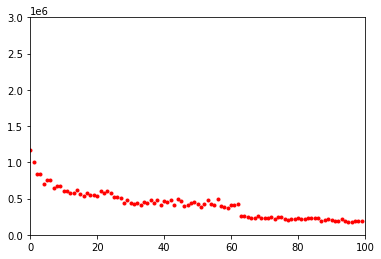

(135795018, 149836100)

In [ ]:
model = Word2Vec(window = 5, min_count = 5)
model.build_vocab(sentences)  # prepare the model vocabulary
model.train(sentences, total_examples=model.corpus_count, epochs=100, compute_loss = True, callbacks=[callback()])

In [ ]:
#save word2vec embeddings for model training
word_vectors = model.wv
word_vectors.save("/content/drive/My Drive/word2vec_tokenup")

In [ ]:
#word2vec_tokenup 100 epochs with sentences (only token embeddings)
#word2vec_100e 100 epochs with with_sw (with stop words)

In [10]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

glove_embedding = WordEmbeddings("/content/drive/My Drive/word2vec_tokenup")
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [98]:
#this model recommends training with 50 topics or above
topic_model = BERTopic(nr_topics = 5, calculate_probabilities = True, embedding_model = document_glove_embeddings)

In [99]:
topics, probabilities = topic_model.fit_transform(docs_clean) 

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:126: UserWarning:

A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 70 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.



In [ ]:
topic_model.get_topic_freq().head(10)

In [101]:
#remove stop words and change n-gram range
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 2), stop_words="english")

topic_model.update_topics(new_tokens, topics, vectorizer_model=cv)

In [ ]:
topic_model.get_topic_freq().head(10)

In [96]:
topic_model.save('/content/drive/My Drive/word2vec_10')

In [97]:
np.save('/content/drive/My Drive/topic_10', topics)
np.save('/content/drive/My Drive/prob_10', probabilities)

In [ ]:
# ALL FITTED TO DOCS_CLEAN
#word2vec_tokenmodel50topic without stopwords and n-gram 1,1
   #topic_w2v_1ng
   #prob_w2v_1ng

#word2vec_token_ngram2 without stopwards and n-gram 1,3 also 50 topics
   #prob_w2v_2ng
   #topic_w2v_2ng

#word2vec_10 is without stopwards and n-gram 1, 2 with 10 topics
   #prob_10
   #topic_10

# FITTED TO NEW_TOKENS
# word2vec_token_15 n-gram 1,2 with 15 topics
  #topic_w2v_15
  #prob_w2v_15

# word2vec_token_10 n-gram 1,2 with 10 topics
  #topic_w2v_10
  #prob_w2v_10

# **W2V ANALYSIS**

In [108]:
best = BERTopic.load('/content/drive/My Drive/word2vec_10')

In [110]:
top = np.load('/content/drive/My Drive/topic_10.npy')
pro = np.load('/content/drive/My Drive/prob_10.npy')

In [157]:
topics_over_time = best.topics_over_time(docs_clean, top, clean_times, evolution_tuning = True,
                         global_tuning = False)

In [158]:
best.visualize_topics_over_time(topics_over_time, top_n=5) #fitted to docs_clean

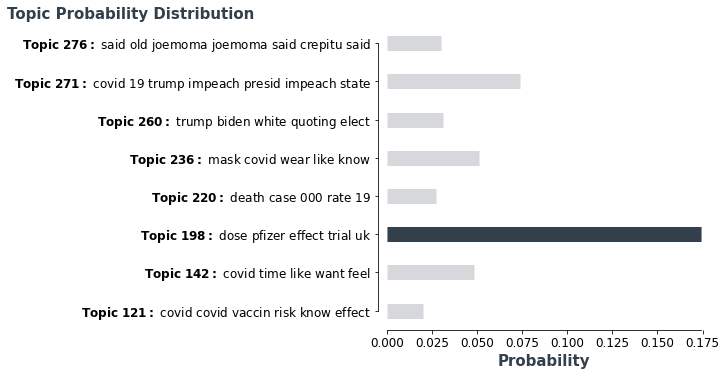

In [199]:
best.visualize_distribution(pro[3])

In [198]:
new_tokens[3]

'quote nelson4lov september 25   2020 pm bitcoin altcoins market drop lately couple reason second wave covid19 fear fud currently round possibly market sell increase number covid19 case death august september turn true sell bad happen march covid19 vaccine long news financial market include crypto market negative turn vaccine approve cure virus problem kind rumor usually turn safe fulfil prophecy \x96buy rumor sell news regular market correction crypto market peak august bitcoin increase more than 3x atl march altcoin significant gain like as low as  2 to  19 market long overdue correction point point reason bitcoin witness decrease price covid19 believe halving last may bitcoin price high time people money fear health challenge big issue moment world'

In [202]:
best.find_topics('covid')

([-1, 121, 142, 236, 220],
 [0.8566866950395018,
  0.7826718560311308,
  0.6796910112700134,
  0.5570599476131947,
  0.3903457854109401])

In [118]:
best2 = BERTopic.load('/content/drive/My Drive/word2vec_token_10')

In [119]:
top2 = np.load('/content/drive/My Drive/topic_w2v_10.npy')
pro2 = np.load('/content/drive/My Drive/prob_w2v_10.npy')

In [155]:
topics_over_time = best2.topics_over_time(new_tokens, top2, clean_times, evolution_tuning = True,
                         global_tuning = False)

In [156]:
best2.visualize_topics_over_time(topics_over_time, top_n=5) #fitted to tokens

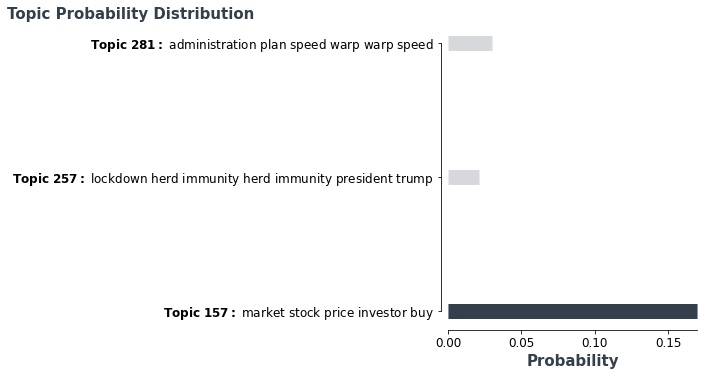

In [200]:
best2.visualize_distribution(pro2[3])

In [201]:
best2.find_topics('covid')

([-1, 184, 173, 81, 257],
 [0.7505358366044297,
  0.6673080931468828,
  0.3943508153389468,
  0.21426454718058077,
  0.16730388968703938])

In [ ]:
oh = BERTopic.load('/content/drive/My Drive/word2vec_tokenmodel50topic')

# **FastText Embeddings** 



In [ ]:
from gensim.models import FastText 

modeling = FastText(size=100, window=5, min_count=5) 
modeling.build_vocab(sentences=sentences)
modeling.train(sentences, total_examples=len(sentences), epochs=100, compute_loss=True)  # train

In [ ]:
word_vectorss = modeling.wv
word_vectorss.save("/content/drive/My Drive/fasttext")

In [ ]:
#fasttext trained with 100e on tokens
#fasttext_sw trained with 100e with stop words in sentences

In [ ]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

glove_embedding = WordEmbeddings("/content/drive/My Drive/fasttext")
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [ ]:
topic_modeling = BERTopic(nr_topics = 10, calculate_probabilities = True, embedding_model=document_glove_embeddings)

In [ ]:
topics, probabilities = topic_modeling.fit_transform(new_tokens)

In [ ]:
#remove stop words and change n-gram range
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 3), stop_words="english")
topic_modeling.update_topics(new_tokens, topics, vectorizer_model=cv)

In [ ]:
topic_modeling.get_topic_freq().head(20)

In [ ]:
topic_modeling.get_topic(97)

In [ ]:
np.save('/content/drive/My Drive/array_topics_ft10', topics)
np.save('/content/drive/My Drive/array_probabilities_ft10', probabilities)

In [ ]:
topic_modeling.save('/content/drive/My Drive/fasttext_10_ng2')

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
#FITTED WITH NEW_TOKENS

#fasttext_50 model with topic reduction to 50
    #array_topics_ftno fitted with new_tokens, 50 topics, cv, n-gram 1,1
    #array_probabilities_ftno fitted with new_tokens, 50 topics, cv, n-gram 1, 1

#fasttext_15_ng2 model with n-gram changed to 1,2 and topic size is 15
    #array_topics_ft15 fitted with new_tokens
    #array_probabilities_ft15

#fasttext_10_ng2 model with n-gram changed to 1,2 and topic size is 10
    #array_topics_ft10 fitted with new_tokens
    #array_probabilities_ft10


# **FASTTEXT ANALYSIS**

In [132]:
bestf = BERTopic.load('/content/drive/My Drive/fasttext_10_ng2')
topf = np.load('/content/drive/My Drive/array_topics_ft10.npy')
prof = np.load('/content/drive/My Drive/array_probabilities_ft10.npy')

In [ ]:
bestf.get_topic_freq().head(6)

In [167]:
topics_over_time = bestf.topics_over_time(new_tokens, topf, clean_times, evolution_tuning = True,
                         global_tuning = False)

In [168]:
bestf.visualize_topics_over_time(topics_over_time, topics = [70,176,290,368,378])

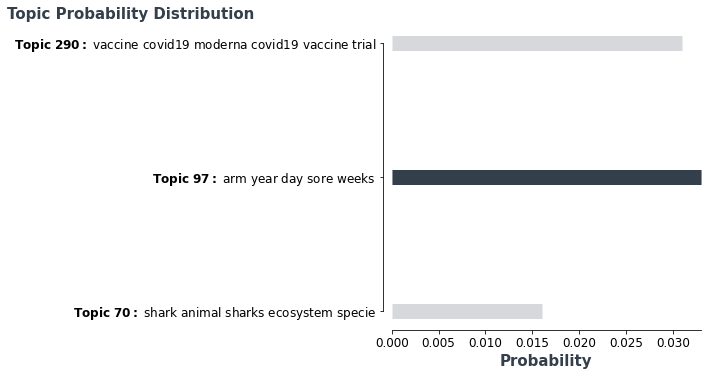

In [206]:
bestf.visualize_distribution(prof[3])

In [210]:
bestf.find_topics("covid")

([-1, 176, 290, 264, 156],
 [0.7619295578389759,
  0.5224152148982532,
  0.3816241651274538,
  0.3634569509126971,
  0.26850584838515357])

In [ ]:
bestf2 = BERTopic.load('/content/drive/My Drive/fasttext_15_ng2')
topf2 = np.load('/content/drive/My Drive/array_topics_ft15.npy')
prof2 = np.load('/content/drive/My Drive/array_probabilities_ft15.npy')

In [171]:
topics_over_time = bestf2.topics_over_time(new_tokens, topf2, clean_times, evolution_tuning = True,
                         global_tuning = False)

In [173]:
bestf2.visualize_topics_over_time(topics_over_time, topics=[63,102,105,264,331])

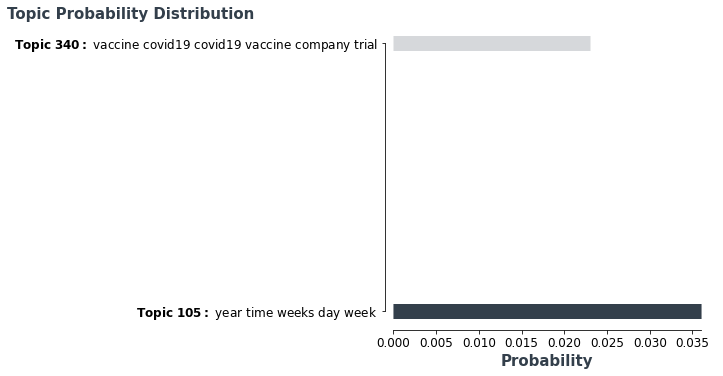

In [208]:
bestf2.visualize_distribution(prof2[3])

In [209]:
bestf2.find_topics("covid")


([-1, 102, 312, 264, 340],
 [0.7601078047263611,
  0.46351903996075755,
  0.38604884589988525,
  0.37059165961729584,
  0.3632601630284634])

# **Sentence Transformers**

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from torch import nn

# Use BERT for mapping tokens to embeddings
word_embedding_model = models.Transformer('bert-base-uncased')

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

sentence_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
embeddings = sentence_model.encode(docs, show_progress_bar=True)

In [ ]:
topic_model = BERTopic(nr_topics = 10, calculate_probabilities=True)

In [ ]:
topics, probabilities = topic_model.fit_transform(docs_clean, embeddings)

# **Testing BERTopic**

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,17925,-1_flu_countri_come_start
1,201,1496,201_idiot_decim_altern_clearli
2,144,1067,144_england_scotland_prestwick_coolsharpharp
3,29,993,29_impeach_presid_devot_trump
4,108,945,108_park_march_stay_alcohol
5,181,882,181_chanc_booster_catch_mutat
6,283,733,283_southern_msm_hemispher_regular
7,269,671,269_hide_idea_prove_scienc
8,279,488,279_januari_uninsur_serolog_test
9,149,446,149_flat_freyasman_alabama_ohio


In [214]:
def find_docs(topic_id):
    x = []
    for idx, item in enumerate(top2):
        if top2[idx]==topic_id:
            x.append(idx)
    return x

In [215]:
found_docs = find_docs(3)

In [216]:
for i in range(5):   
    print(f"Document: {found_docs[i]}")
    print("-----------")
    print(new_tokens[found_docs[i]]) 
    print("-----------")
    print()


Document: 0
-----------
deserve planet
-----------

Document: 6
-----------
stop destroy ecosystem
-----------

Document: 9
-----------
completely utterly unethical immoral
-----------

Document: 12
-----------
marine predator balance ocean mess ocean suffer wake
-----------

Document: 13
-----------
life precious decimate species endanger answer option explore
-----------



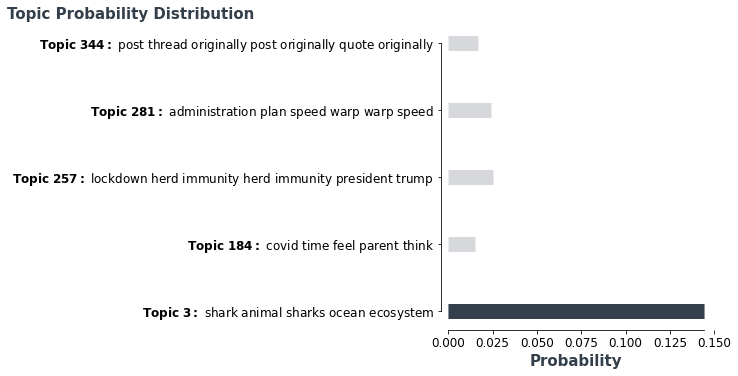

In [227]:
best2.visualize_distribution(pro2[found_docs[1]])

In [ ]:
oh = BERTopic.load('/content/drive/My Drive/my_model1')

In [ ]:
my = BERTopic.load('/content/drive/My Drive/fasttext1_model')